In [1]:
# !gdown 1dG0ZLEpkGbXEp-YEIh5cE3puWRSrmxy5
# !gdown 11eeqeYvccC4MBOgOUMMKjJgxws-Be4vC
# !gdown 1qf_OCmZSFf7X2TCmErSfp1J2J458_Mhv
!gdown 1pNUpy1poeGXTiSAXtBBqBD0RWj8qzjsF

Downloading...
From: https://drive.google.com/uc?id=1pNUpy1poeGXTiSAXtBBqBD0RWj8qzjsF
To: /content/sents_df_100.pkl
100% 6.28M/6.28M [00:00<00:00, 309MB/s]


In [39]:
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import classification_report
from pathlib import Path
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.insert(0, '..')

In [4]:
from functions.utils import get_file, save_file
from functions.bert import Dataset, BertClassifier, train_model, evaluate_model, inference_model

In [5]:
SEED = 42

In [6]:
# data = get_file('sents_df.pkl')

data = get_file('sents_df_100.pkl')

In [7]:
data.tail()

,file_name,snt_order,sentence,sentence_clear,data_split,target,sent_clear_len
7092,ff6882cb4a3ec31dec18a94e1d1745b1.doc,47,8.3. Настоящий договор действует до момента ок...,настоящий договор действует до момента окончан...,test,Договоры купли-продажи,12
7093,ff6882cb4a3ec31dec18a94e1d1745b1.doc,48,8.4. Настоящий договор не является заключенным...,настоящий договор не является заключенным с ус...,test,Договоры купли-продажи,13
7094,ff6882cb4a3ec31dec18a94e1d1745b1.doc,49,8.5. Настоящий договор подписан в двух экземпл...,настоящий договор подписан в двух экземплярах ...,test,Договоры купли-продажи,16
7095,ff6882cb4a3ec31dec18a94e1d1745b1.doc,50,"8.6. Во всем остальном, что не предусмотрено н...",во всем остальном что не предусмотрено настоящ...,test,Договоры купли-продажи,17
7096,ff6882cb4a3ec31dec18a94e1d1745b1.doc,51,9. Реквизиты Продавца и Покупателя Продавец: О...,реквизиты продавца и покупателя продавец огрн ...,test,Договоры купли-продажи,59


In [8]:
data.shape[0]

7090

In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
bert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

# tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
# bert_model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
idx2item = dict(enumerate(data.target.unique()))
item2idx = {v: k for k, v in idx2item.items()}

n_cats = data.target.nunique()

print(n_cats, idx2item, item2idx)

5 {0: 'Договоры оказания услуг', 1: 'Договоры подряда', 2: 'Договоры купли-продажи', 3: 'Договоры аренды', 4: 'Договоры поставки'} {'Договоры оказания услуг': 0, 'Договоры подряда': 1, 'Договоры купли-продажи': 2, 'Договоры аренды': 3, 'Договоры поставки': 4}


In [12]:
data_train = data[data.data_split == 'train'][['sentence_clear', 'target', 'file_name', 'snt_order', 'sentence']]
data_val = data[data.data_split == 'val'][['sentence_clear', 'target', 'file_name', 'snt_order', 'sentence']]
data_test = data[data.data_split == 'test'][['sentence_clear', 'target', 'file_name', 'snt_order', 'sentence']]

In [13]:
data_train.shape[0], data_val.shape[0], data_test.shape[0]

(5052, 1031, 1007)

In [14]:
MAX_LEN = 100

In [15]:
train_data = Dataset(data_train, tokenizer, MAX_LEN, item2idx)
val_data = Dataset(data_val, tokenizer, MAX_LEN, item2idx)
test_data = Dataset(data_test, tokenizer, MAX_LEN, item2idx)

100%|██████████| 1007/1007 [00:00<00:00, 4399.90it/s]


In [16]:
OUTP_DIM = 312
# OUTP_DIM = 768
BATCH_SIZE = 4
LR = 7e-7
EPOCHS = 30

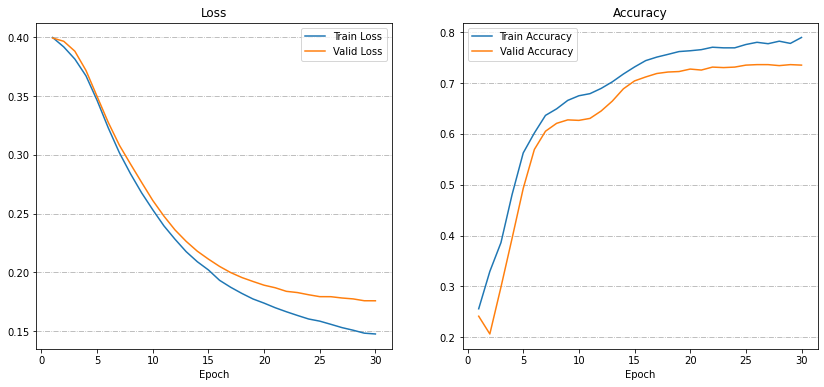

Val Loss: 0.148		 Val Accuracy: 0.735


In [17]:
torch.cuda.empty_cache()
model = BertClassifier(bert_model, n_cats, OUTP_DIM)

train_model(model, train_data, val_data, BATCH_SIZE, LR, EPOCHS)

In [ ]:
# 80: Val Loss: 0.154		 Val Accuracy: 0.714

In [31]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [32]:
SAVE_PATH = Path('/content/gdrive/MyDrive/zavodit')

In [33]:
torch.save(model.state_dict(), SAVE_PATH / 'rubert_tiny_state_dict.pkl')
save_file(tokenizer, SAVE_PATH / 'tokenizer_rubert.pkl')
save_file(idx2item, SAVE_PATH / 'idx2item.pkl')

'Done'

In [ ]:
model = get_file(SAVE_PATH / 'rubert_tiny.pkl')
tokenizer = get_file(SAVE_PATH / 'tokenizer_rubert.pkl')
idx2item = get_file(SAVE_PATH / 'idx2item.pkl')

In [60]:
# Оценка на валидационной выборке

pred_labels, pred_probs = evaluate_model(model, val_data, BATCH_SIZE, return_proba=True)

data_val_with_preds = data_val.copy()

data_val_with_preds['target_pred'] = pred_labels
data_val_with_preds['pred_proba'] = pred_probs
data_val_with_preds['target_pred'] = data_val_with_preds['target_pred'].map(idx2item)

print('\nVAL DATA (sentences):\n', classification_report(data_val_with_preds.target, data_val_with_preds.target_pred))

100%|██████████| 258/258 [00:00<00:00, 307.73it/s]

Accuracy:  0.735

VAL DATA (sentences):
                          precision    recall  f1-score   support

        Договоры аренды       0.81      0.75      0.78       204
 Договоры купли-продажи       0.87      0.58      0.70       176
Договоры оказания услуг       0.51      0.79      0.62       148
       Договоры подряда       0.90      0.74      0.81       298
      Договоры поставки       0.66      0.80      0.72       205

               accuracy                           0.74      1031
              macro avg       0.75      0.73      0.73      1031
           weighted avg       0.77      0.74      0.74      1031



In [61]:
data_val_with_preds['true_pos'] = (data_val_with_preds.target == data_val_with_preds.target_pred).astype(int)
true_share_by_snt_order = data_val_with_preds.groupby('snt_order').true_pos.mean()

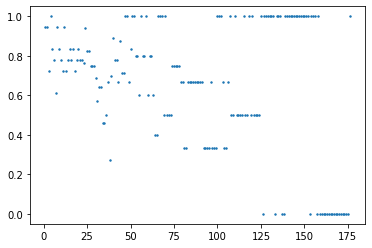

In [62]:
plt.scatter(true_share_by_snt_order.index, true_share_by_snt_order.values, s=2)
plt.show()

In [63]:
print('\nTEST DATA (sentences):\n', classification_report(data_val_with_preds[data_val_with_preds.snt_order < 150].target,
                                                          data_val_with_preds[data_val_with_preds.snt_order < 150].target_pred))


TEST DATA (sentences):
                          precision    recall  f1-score   support

        Договоры аренды       0.82      0.75      0.79       204
 Договоры купли-продажи       0.87      0.58      0.70       176
Договоры оказания услуг       0.53      0.79      0.63       148
       Договоры подряда       0.90      0.79      0.84       271
      Договоры поставки       0.68      0.80      0.73       205

               accuracy                           0.75      1004
              macro avg       0.76      0.74      0.74      1004
           weighted avg       0.78      0.75      0.75      1004



In [65]:
data_val_with_preds['cl_sent_len'] = data_val_with_preds['sentence_clear'].apply(len)

In [69]:
data_val_with_preds[data_val_with_preds.cl_sent_len < 100]

,sentence_clear,target,file_name,snt_order,sentence,target_pred,pred_proba,true_pos,cl_sent_len
82,работа выполняется за риск подрядчика заказчика,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,3,1.2. Работа выполняется за риск ______________...,Договоры подряда,0.919168,1,47
85,подрядчик привлечь к исполнению своих обязател...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,6,Подрядчик _________________________ привлечь к...,Договоры подряда,0.905730,1,82
87,подрядчик гарантирует качество выполненной раб...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,8,Подрядчик гарантирует качество _______________...,Договоры подряда,0.934042,1,59
90,при просрочке выполнения работ по устранению н...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,11,При просрочке выполнения работ по устранению н...,Договоры подряда,0.936662,1,95
92,дата предусмотренные пункт договора работы вып...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,13,(дата) 2.6. Предусмотренные пункт 1.1 договора...,Договоры подряда,0.900750,1,74
...,...,...,...,...,...,...,...,...,...
6212,the contractor hereby undertakes to perform th...,Договоры оказания услуг,d54c0b06162cf7cf57e8b1e7356aa204.doc,14,2.1. The Contractor hereby undertakes to perfo...,Договоры аренды,0.407223,0,90
6232,the cost of services includes participation in...,Договоры оказания услуг,d54c0b06162cf7cf57e8b1e7356aa204.doc,34,3.3. The cost of Services includes participati...,Договоры оказания услуг,0.878156,1,89
6233,датой оплаты считается дата списания денежных ...,Договоры оказания услуг,d54c0b06162cf7cf57e8b1e7356aa204.doc,35,Датой оплаты считается дата списания денежных ...,Договоры оказания услуг,0.623850,1,98
6264,this agreement is made in two equally valid co...,Договоры оказания услуг,d54c0b06162cf7cf57e8b1e7356aa204.doc,66,5.5. This Agreement is made in two equally val...,Договоры оказания услуг,0.571934,1,92


In [66]:
true_share_by_snt_len = data_val_with_preds.groupby('cl_sent_len').true_pos.mean()

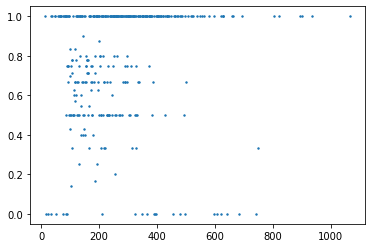

In [68]:
plt.scatter(true_share_by_snt_len.index, true_share_by_snt_len.values, s=2)
plt.show()

In [50]:
pred_df = data_val_with_preds.groupby('file_name').target_pred.value_counts(normalize=True).to_frame()
pred_df.columns = ['proba']
pred_df.reset_index(inplace=True)

true_df = data_val_with_preds[['file_name', 'target']].drop_duplicates()

pred_df = pred_df.merge(true_df)
pred_df['ord'] = pred_df.groupby('file_name').cumcount()

Посмотрим на предложения, в принадлежности которых к самому частому классу модель наиболее сильно уверена 

In [51]:
most_imp_snts = data_val_with_preds.merge(pred_df[['file_name', 'target_pred']], how='right') \
    .sort_values(by=['file_name', 'pred_proba'], ascending=[True, False])

most_imp_snts['aware_ord'] = most_imp_snts.groupby('file_name').cumcount()

In [52]:
most_imp_snts[most_imp_snts.aware_ord < 5].sentence.values[:5]

array(['ОТВЕТСТВЕННОСТЬ СТОРОН 5.1. При неисполнении, ненадлежащем исполнении принятых на себя обязательств стороны несут следующую ответственность: Подрядчик: — за некачественное выполнение работ — _______________________; (мера ответственности) — за просрочку выполнения работ — ____________________________; (мера ответственности) — за непередачу оговоренной в пункт 4.7 договора информации — ___________________________________________________________________.',
       'Заказчик оплачивает Подрядчику обусловленную пункт 3.1 договора стоимость работ ____________________________________________________________________________ (указать порядок оплаты — после окончания работы согласно акту приемки, или досрочно в качестве предоплаты, или иной порядок) (срок) ____________________________________________________________________________ ____________________________________ в течение ____________________.',
       'При просрочке выполнения работ по устранению недостатков Подрядчик несет ответс

In [53]:
pred_df[pred_df.ord == 0]

,file_name,target_pred,proba,target,ord
0,03a70fe60be9ecc2a63798a361fc9689.docx,Договоры подряда,0.828571,Договоры подряда,0
4,073a0d372820c3c2bffe9ba24a7ed7af.doc,Договоры купли-продажи,0.692308,Договоры купли-продажи,0
8,084edc7dfc3db04e3a3c55c102f47bcb.doc,Договоры аренды,0.882353,Договоры аренды,0
12,086ad48895d2a73854b6151decc28800.pdf,Договоры купли-продажи,0.627451,Договоры купли-продажи,0
17,0ca2f9faecdbc67d6686a9f5b6636eba.doc,Договоры купли-продажи,0.736842,Договоры купли-продажи,0
21,137eaaa047f557233943012897e46cec.doc,Договоры поставки,0.512821,Договоры купли-продажи,0
25,2fd747f38e30ae7ce1c9d6e3b907ac5d.doc,Договоры поставки,0.739130,Договоры поставки,0
30,6b18c046e7ccfdaf9123c11980f56c35.doc,Договоры подряда,0.720930,Договоры подряда,0
34,7a120d4c7cec157324effa671e2d0812.docx,Договоры подряда,0.765101,Договоры подряда,0
38,86d6d0062e91651ccc3d3ce35b162bf8.doc,Договоры купли-продажи,0.500000,Договоры купли-продажи,0


In [54]:
print('\nVAL DATA (Documents):\n', classification_report(pred_df[pred_df.ord == 0].target, pred_df[pred_df.ord == 0].target_pred))


VAL DATA (Documents):
                          precision    recall  f1-score   support

        Договоры аренды       1.00      1.00      1.00         3
 Договоры купли-продажи       1.00      0.80      0.89         5
Договоры оказания услуг       1.00      1.00      1.00         3
       Договоры подряда       1.00      1.00      1.00         4
      Договоры поставки       0.75      1.00      0.86         3

               accuracy                           0.94        18
              macro avg       0.95      0.96      0.95        18
           weighted avg       0.96      0.94      0.95        18



In [56]:
# Оценка на тестовой выборке

pred_test_labels, pred_test_probs = inference_model(model, test_data, BATCH_SIZE, return_proba=True)

data_test_with_preds = data_test.copy()

data_test_with_preds['target_pred'] = pred_test_labels
data_test_with_preds['pred_proba'] = pred_test_probs
data_test_with_preds['target_pred'] = data_test_with_preds['target_pred'].map(idx2item)

print('\nTEST DATA (sentences):\n', classification_report(data_test_with_preds.target, data_test_with_preds.target_pred))

100%|██████████| 252/252 [00:01<00:00, 188.82it/s]



TEST DATA (sentences):
                          precision    recall  f1-score   support

        Договоры аренды       0.69      0.83      0.76        99
 Договоры купли-продажи       0.94      0.51      0.66       177
Договоры оказания услуг       0.78      0.80      0.79       409
       Договоры подряда       0.72      0.71      0.71       181
      Договоры поставки       0.57      0.78      0.66       141

               accuracy                           0.73      1007
              macro avg       0.74      0.73      0.72      1007
           weighted avg       0.76      0.73      0.73      1007



In [58]:
data_test_with_preds.snt_order.value_counts()

1      18
8      18
16     18
13     18
12     18
       ..
107     1
108     1
109     1
110     1
146     1
Name: snt_order, Length: 146, dtype: int64

In [57]:
print('\nTEST DATA (sentences):\n', classification_report(data_test_with_preds[data_test_with_preds.snt_order < 150].target,
                                                          data_test_with_preds[data_test_with_preds.snt_order < 150].target_pred))


TEST DATA (sentences):
                          precision    recall  f1-score   support

        Договоры аренды       0.69      0.83      0.76        99
 Договоры купли-продажи       0.94      0.51      0.66       177
Договоры оказания услуг       0.78      0.80      0.79       409
       Договоры подряда       0.72      0.71      0.71       181
      Договоры поставки       0.57      0.78      0.66       141

               accuracy                           0.73      1007
              macro avg       0.74      0.73      0.72      1007
           weighted avg       0.76      0.73      0.73      1007



In [25]:
pred_df = data_test_with_preds.groupby('file_name').target_pred.value_counts(normalize=True).to_frame()
pred_df.columns = ['proba']
pred_df.reset_index(inplace=True)

true_df = data_test_with_preds[['file_name', 'target']].drop_duplicates()

pred_df = pred_df.merge(true_df)
pred_df['ord'] = pred_df.groupby('file_name').cumcount()

In [26]:
most_imp_snts = data_test_with_preds.merge(pred_df[['file_name', 'target_pred']], how='right') \
    .sort_values(by=['file_name', 'pred_proba'], ascending=[True, False])

most_imp_snts['aware_ord'] = most_imp_snts.groupby('file_name').cumcount()

In [27]:
print('\nTEST DATA (Documents):\n', classification_report(pred_df[pred_df.ord == 0].target, pred_df[pred_df.ord == 0].target_pred))


TEST DATA (Documents):
                          precision    recall  f1-score   support

        Договоры аренды       1.00      1.00      1.00         3
 Договоры купли-продажи       1.00      0.75      0.86         4
Договоры оказания услуг       0.83      1.00      0.91         5
       Договоры подряда       1.00      1.00      1.00         3
      Договоры поставки       1.00      1.00      1.00         3

               accuracy                           0.94        18
              macro avg       0.97      0.95      0.95        18
           weighted avg       0.95      0.94      0.94        18



In [ ]:
# Посмотрим, где ошиблась модель

data_val_with_preds[data_val_with_preds.target != data_val_with_preds.target_pred]

,sentence_clear,target,file_name,snt_order,sentence,target_pred
98,предмет договора,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,2,ПРЕДМЕТ ДОГОВОРА 1.1.,Договоры оказания услуг
106,вправе не вправе,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,10,"(вправе, не вправе) 2.3.",Договоры оказания услуг
110,сроки устранения недостатков неисправностей с ...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,14,"Сроки устранения недостатков, неисправностей _...",Договоры оказания услуг
113,дата,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,17,(дата) 2.6.,Договоры оказания услуг
116,если сторона благодаря исполнению своего обяза...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,20,Если сторона благодаря исполнению своего обяза...,Договоры оказания услуг
...,...,...,...,...,...,...
8539,should the parties fail to settle their disput...,Договоры оказания услуг,d54c0b06162cf7cf57e8b1e7356aa204.doc,74,Should the Parties fail to settle their disput...,Договоры поставки
8543,the arbitration award shall be final and bindi...,Договоры оказания услуг,d54c0b06162cf7cf57e8b1e7356aa204.doc,78,The arbitration award shall be final and bindi...,Договоры аренды
8546,настоящий договор составлен в двух экземплярах...,Договоры оказания услуг,d54c0b06162cf7cf57e8b1e7356aa204.doc,81,5.5. Настоящий Договор составлен в двух экземп...,Договоры купли-продажи
8551,сообщение или документ считаются полученными с...,Договоры оказания услуг,d54c0b06162cf7cf57e8b1e7356aa204.doc,86,Сообщение или документ считаются полученными С...,Договоры поставки


In [ ]:
data_val_with_preds

,sentence_clear,target,target_pred
97,договор от именуемое в дальнейшем подрядчик в ...,Договоры подряда,Договоры подряда
98,предмет договора,Договоры подряда,Договоры оказания услуг
99,подрядчик обязуется выполнить по заданию заказ...,Договоры подряда,Договоры подряда
100,работа выполняется за риск подрядчика заказчика,Договоры подряда,Договоры подряда
101,сроки и способы выполнения работы,Договоры подряда,Договоры подряда
...,...,...,...
8559,legal addresses and bank details of the partie...,Договоры оказания услуг,Договоры оказания услуг
8560,рекомендуется устанавливать срок не более дней...,Договоры оказания услуг,Договоры оказания услуг
8561,в зависимости от вида услуг и места проведения...,Договоры оказания услуг,Договоры оказания услуг
8562,в случае проведения мероприятия на территории ...,Договоры оказания услуг,Договоры оказания услуг


In [ ]:
# Оценка на тестовой выборке

pred_test_labels = inference_model(model, test_data, BATCH_SIZE)

data_test_with_preds = data_test.copy()

data_test_with_preds['target_pred'] = pred_test_labels
data_test_with_preds['target_pred'] = data_test_with_preds['target_pred'].map(idx2item)

print('\nTEST DATA:\n', classification_report(data_test_with_preds.target, data_test_with_preds.target_pred))

100%|██████████| 3/3 [00:00<00:00,  6.24it/s]


TEST DATA:
                                                    precision    recall  f1-score   support

        Договоры для акселератора/Договоры аренды       1.00      1.00      1.00         3
 Договоры для акселератора/Договоры купли-продажи       1.00      1.00      1.00         4
Договоры для акселератора/Договоры оказания услуг       1.00      1.00      1.00         5
       Договоры для акселератора/Договоры подряда       1.00      1.00      1.00         3
      Договоры для акселератора/Договоры поставки       1.00      1.00      1.00         3

                                         accuracy                           1.00        18
                                        macro avg       1.00      1.00      1.00        18
                                     weighted avg       1.00      1.00      1.00        18

